In [1]:
import os
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TestTubeLogger
import torch
import wandb

from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision.transforms import Compose
from torch.nn import functional as F
import torchvision.models.resnet as resnet
import torch.nn as nn
from torchvision.datasets import Cityscapes
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import LambdaLR

import matplotlib
import matplotlib.cm
from matplotlib.font_manager import findfont, FontProperties
from PIL import Image, ImageFont, ImageDraw
from torchvision.utils import make_grid


from typing import Optional, Union, Tuple, List, Any, BinaryIO
from types import FunctionType
import sys
import numpy as np
from PIL import Image
from tqdm import tqdm
import OpenEXR as exr
import Imath
from path import Path
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from dotenv import load_dotenv
import os
from datetime import datetime
import uuid

import pdb
from datasets_miniscapes import DatasetMiniscapes
from definitions import *
from transforms import *

In [2]:
%matplotlib widget

In [3]:
# set up weights and biases
load_dotenv()  # take environment variables from .env
WANDB_API_KEY = os.environ.get('WAND_API_KEY')
WANDB_DIR = "./TEMPDIR"
WANDB_CACHE_DIR = "./TEMPDIR"
WANDB_CONFIG_DIR = "./TEMPDIR"

In [3]:
if 0:
    # from source.datasets.definitions
    MOD_ID = 'id'
    MOD_RGB = 'rgb'
    MOD_SEMSEG = 'semseg'
    MOD_DEPTH = 'depth'
    
    SPLIT_TRAIN = 'train'
    SPLIT_VALID = 'val'
    SPLIT_TEST = 'test'
    
    INVALID_VALUE = float('-inf')
    
    INTERP = {
        MOD_ID: None,
        MOD_RGB: 'bilinear',
        MOD_SEMSEG: 'nearest',
        MOD_DEPTH: 'nearest',
    }


### Define Datasets

In [4]:
# create datasets objects
# first read all number of files in root/semseg, root/depth, root/rgb
root_dir = Path("C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/")
flist_seg = glob.glob(root_dir/"semseg_filt/*.png")
flist_depth = glob.glob(root_dir/"depth/*.exr")
flist_cam = glob.glob(root_dir/"rgb/*.png")

assert len(flist_seg) == len(flist_depth), "number of files in class folder is not same as depth folder"
assert len(flist_seg) == len(flist_cam), "number of files in class folder is not same as cam folder"

num_datapts = len(flist_seg)
# create train, val, test indx
X_train, X_test, y_train, y_test = train_test_split(np.arange(1,num_datapts+1), np.arange(1,num_datapts+1), test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
train_idx = X_train
val_idx = X_val
test_idx = X_test
# create datasets
train_ds = DatasetMiniscapes(root_dir, train_idx)
val_ds = DatasetMiniscapes(root_dir, val_idx)
test_ds = DatasetMiniscapes(root_dir, test_idx)

### Define Transforms

#### Understanding transforms

In [6]:
def _transform_scale_rotate_wiggle(dst_size, scale_min, scale_max, angle_max_deg, wiggle_max_ratio):
    corners = [
        np.array([-dst_size[0] / 2, -dst_size[1] / 2], dtype=np.float32),
        np.array([-dst_size[0] / 2, dst_size[1] / 2], dtype=np.float32),
        np.array([dst_size[0] / 2, dst_size[1] / 2], dtype=np.float32),
        np.array([dst_size[0] / 2, -dst_size[1] / 2], dtype=np.float32)
    ] 

    # get the max wiggle in terms of pixels, NOTE: wiggle_max_ratio: [0, 1/2], so max wiggle is 1/4*min(W,H) of cropped size
    max_wiggle_pix = wiggle_max_ratio * min(dst_size[0], dst_size[1]) / 2
    
    scale = np.random.uniform(scale_min, scale_max)
    angle_deg = np.random.uniform(-angle_max_deg, angle_max_deg) if 0 < angle_max_deg <= 45 else 0
    wiggle_factor = [
        np.array([
            np.random.uniform(-max_wiggle_pix, max_wiggle_pix),
            np.random.uniform(-max_wiggle_pix, max_wiggle_pix)
        ], dtype=np.float32) for _ in range(4)
    ]

    angle_rad = np.deg2rad(angle_deg)
    matrix_rot = np.array([
        [np.cos(angle_rad), np.sin(-angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ], dtype=np.float32)

    
    # wiggle is just added to crop size, wiggle is like adding random noise in corner positions of image so that crop size is not fixed
    corners = [np.matmul(matrix_rot, scale * (c + w)) for c, w in zip(corners, wiggle_factor)]
    return corners, scale

def _dst_corners_bounding_box(corners):
    x_min, x_max = corners[0][0], corners[0][0]
    y_min, y_max = corners[0][1], corners[0][1]
    for corner in corners[1:]:
        x_min = min(x_min, corner[0])
        x_max = max(x_max, corner[0])
        y_min = min(y_min, corner[1])
        y_max = max(y_max, corner[1])
    return x_min, x_max, y_min, y_max

def _generate_corners(
            src_size, dst_size, random_scale_min=1.0, random_scale_max=2.0,
            random_tilt_max_deg=0.0, random_wiggle_max_ratio=0.0, center_offset_instead_of_random=False
    ):
    assert random_scale_min > 0, 'random_scale_min must be positive'
    assert random_scale_max >= random_scale_min, 'random_scale_max > random_scale_min'
    assert random_tilt_max_deg >= 0, 'tilt must be non negative'
    assert 0 <= random_wiggle_max_ratio < 0.5, 'random_wiggle_max_ratio must be [0, 1/2]'

    corners, scale = _transform_scale_rotate_wiggle(
        dst_size, random_scale_min, random_scale_max, random_tilt_max_deg, random_wiggle_max_ratio
    )
    # Here we get the crop cordinates in the source image, note these will be w.r.t center at middle of cropped image
    x_min, x_max, y_min, y_max = _dst_corners_bounding_box(corners)
    print(f"Inside: {x_min, x_max, y_min, y_max}")
    # The code below add random offset to crop cordinates and ensures that cordinates are positive where origin is at top left of src image
    range_x_min = -x_min
    range_x_max = src_size[0] - x_max
    range_y_min = -y_min
    range_y_max = src_size[1] - y_max

    if center_offset_instead_of_random or range_x_max <= range_x_min:
        offs_x = (range_x_min + range_x_max) * 0.5
    else:
        offs_x = np.random.uniform(range_x_min, range_x_max)

    if center_offset_instead_of_random or range_y_max <= range_y_min:
        offs_y = (range_y_min + range_y_max) * 0.5
    else:
        offs_y = np.random.uniform(range_y_min, range_y_max)

    corners = [c + np.array([offs_x, offs_y], dtype=np.float32) for c in corners]
    return corners, scale

def _perspective_transform_from_corners(corners_src, corners_dst):
    matrix = []
    for p_src, p_dst in zip(corners_src, corners_dst):
        matrix.append([p_src[0], p_src[1], 1, 0, 0, 0, -p_dst[0] * p_src[0], -p_dst[0] * p_src[1]])
        matrix.append([0, 0, 0, p_src[0], p_src[1], 1, -p_dst[1] * p_src[0], -p_dst[1] * p_src[1]])
    A = np.matrix(matrix, dtype=np.float64)
    B = np.array(corners_dst).reshape(8)
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res, dtype=np.float32).reshape(8)

In [7]:
# check the transform on a dataset image
crop_random = 256
random_scale_min= 1.0
random_scale_max= 1.0
random_tilt_max_deg= 0
random_wiggle_max_ratio= 0
random_reflect= False
semseg_ignore_label=train_ds.semseg_ignore_label
src_size = train_ds[0]['rgb'].size

In [8]:
train_ds[0]

{'id': 20399,
 'rgb': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1440x720 at 0x2C715EF5850>,
 'semseg': <PIL.PngImagePlugin.PngImageFile image mode=L size=1440x720 at 0x2C715EF5D90>,
 'depth': <PIL.Image.Image image mode=L size=1440x720 at 0x2C715F0B2E0>}

##### transform on rgb image

corners: [array([-128., -128.], dtype=float32), array([-128.,  128.], dtype=float32), array([128., 128.], dtype=float32), array([ 128., -128.], dtype=float32)], scale: 1.0
-128.0 128.0 -128.0 128.0
Inside: (-128.0, 128.0, -128.0, 128.0)
final:, corners:[array([496.8282 , 243.84204], dtype=float32), array([496.8282 , 499.84204], dtype=float32), array([752.8282 , 499.84204], dtype=float32), array([752.8282 , 243.84204], dtype=float32)], scale:1.0
-------------- after transformation ---------------------------


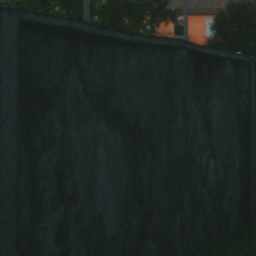

In [11]:
corners, scale = _transform_scale_rotate_wiggle((crop_random,crop_random), random_scale_min, random_scale_max, random_tilt_max_deg, random_wiggle_max_ratio)
print(f"corners: {corners}, scale: {scale}")
x_min, x_max, y_min, y_max = _dst_corners_bounding_box(corners)
print(x_min, x_max, y_min, y_max)
src_corners, src_scale =  _generate_corners(
            src_size, (crop_random,crop_random), random_scale_min=1.0, random_scale_max=1.0,
            random_tilt_max_deg=0.0, random_wiggle_max_ratio=0.0, center_offset_instead_of_random=False
    )
print(f"final:, corners:{src_corners}, scale:{src_scale}")
dst_size = (crop_random,crop_random)
dst_corners = [
            np.array([0, 0], dtype=np.float32),
            np.array([0, dst_size[1]], dtype=np.float32),
            np.array([dst_size[0], dst_size[1]], dtype=np.float32),
            np.array([dst_size[0], 0], dtype=np.float32)
        ]
warp_coef_inv = _perspective_transform_from_corners(dst_corners, src_corners)
data = train_ds[0]['rgb']
data_tf = data.transform(
                    dst_size, Image.PERSPECTIVE, warp_coef_inv, resample=Image.BILINEAR, fillcolor=None
                )
print("-------------- after transformation ---------------------------")
data_tf

---------------------- Before transformation ----------------------------


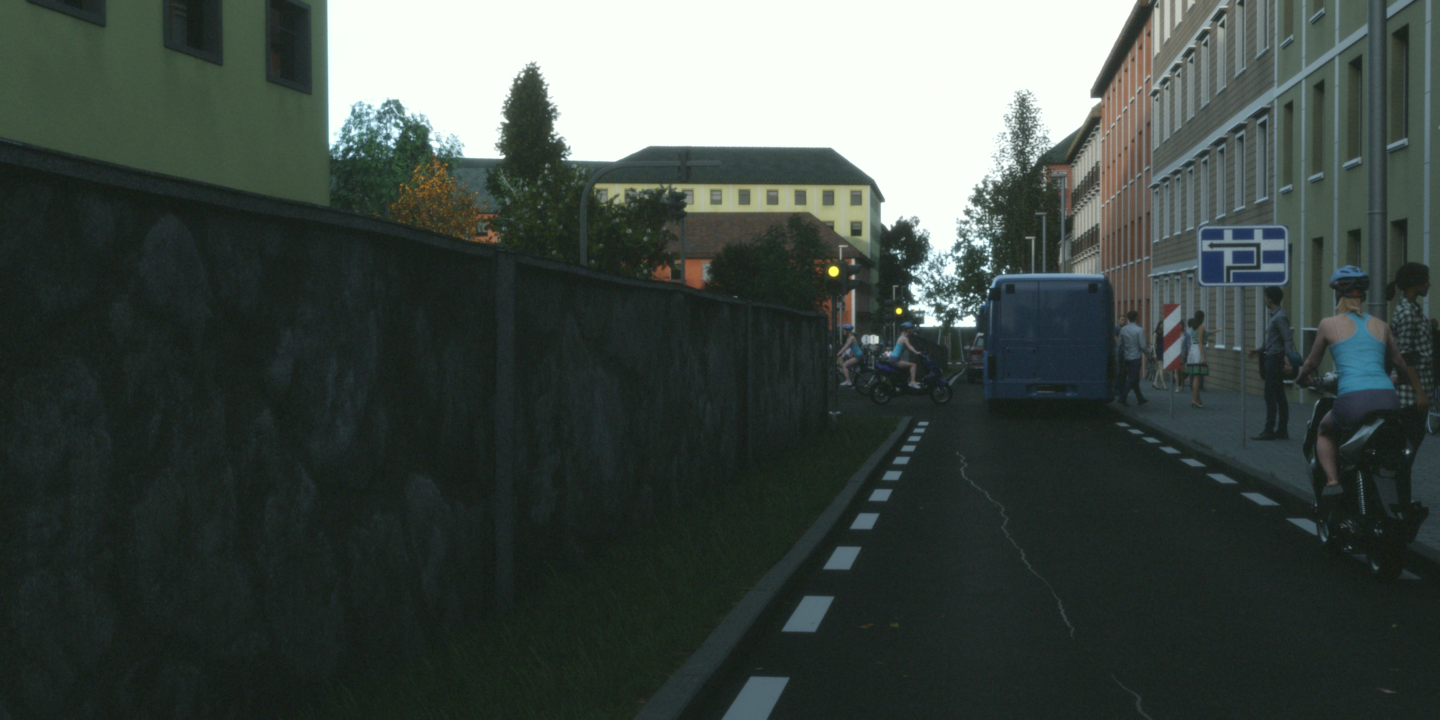

In [12]:
print("---------------------- Before transformation ----------------------------")
data

##### transformation on seg image

-------------- after transformation ---------------------------


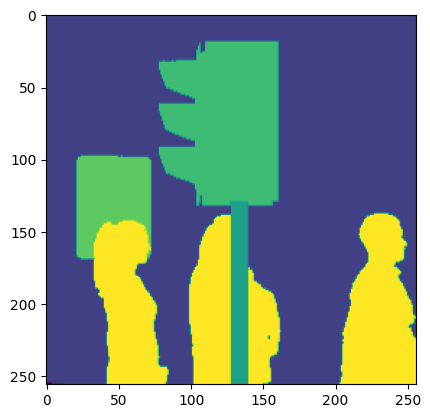

In [12]:
data = train_ds[1090]['semseg']
data_tf = data.transform(
                    dst_size, Image.PERSPECTIVE, warp_coef_inv, resample=Image.BILINEAR, fillcolor=None
                )
print("-------------- after transformation ---------------------------")
plt.figure()
plt.imshow(data_tf)

---------------------- Before transformation ----------------------------


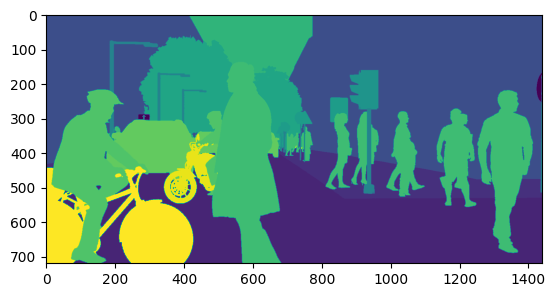

In [13]:
print("---------------------- Before transformation ----------------------------")
plt.figure()
plt.imshow(data)

##### Transformation on disparity image

-------------- after transformation ---------------------------


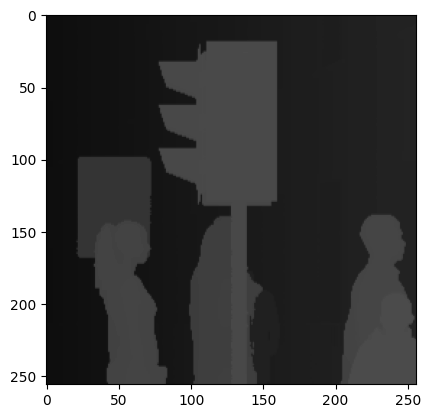

In [14]:
data = train_ds[1090]['depth']
data_tf = data.transform(
                    dst_size, Image.PERSPECTIVE, warp_coef_inv, resample=Image.BILINEAR, fillcolor=None
                )
print("-------------- after transformation ---------------------------")
plt.figure()
plt.imshow(data_tf, vmin=0, vmax=300, cmap='gray')

---------------------- Before transformation ----------------------------


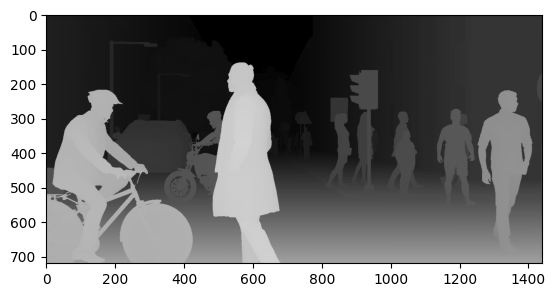

In [15]:
print("---------------------- Before transformation ----------------------------")
plt.figure()
plt.imshow(data, vmin=0, vmax=300, cmap='gray')

### Define Loss functions

In [5]:
class CrossEntropyLoss(torch.nn.CrossEntropyLoss):
    __constants__ = ['ignore_index', 'reduction']
    ignore_index: int

    def __init__(self, weight: Optional[torch.Tensor] = None, size_average=None,
                 ignore_index: int = -100, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(weight, size_average, ignore_index, reduce, reduction)
        self.ignore_index = ignore_index

    @torch.cuda.amp.autocast(enabled=False)
    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return F.cross_entropy(input,
                               target,
                               weight=self.weight,
                               ignore_index=self.ignore_index,
                               reduction=self.reduction
                            )

class SILogLoss(torch.nn.Module):
    def __init__(
            self,
            gamma: float = 0.15,
            eps: float = 1e-5
        ):
        super().__init__()
        self.name: str = self.__class__.__name__
        self.gamma: float = gamma
        self.eps = eps
    
    @torch.cuda.amp.autocast(enabled=False)
    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        # Avoid dummy channel dimension since in this case depth is only single channel data
        if input.ndim == 4:
            input = input.squeeze(1)
        if target.ndim == 4:
            target = target.squeeze(1)
        

        # Implement a proper silog (scale invariant log loss) and taking into consideration
        # the invalid pixels (target is 0).
        # https://guillesanbri.com/Scale-Invariant-Loss/
        input = input.clamp(min=self.eps)
        target = target.clamp(min=self.eps)
        term1 = ((input.log() - target.log())**2).mean(dim=(1,2))
        term2 = ((input.log() - target.log()).mean(dim=(1,2)))**2
        loss = (term1 - self.gamma * term2).mean()
        #loss = (input - target).abs().sum()

        return loss

### Metric for segmentation and Depth

In [6]:
def semseg_compute_confusion(y_hat_lbl, y_lbl, num_classes, ignore_label):
    assert torch.is_tensor(y_hat_lbl) and torch.is_tensor(y_lbl), 'Inputs must be torch tensors'
    assert y_lbl.device == y_hat_lbl.device, 'Input tensors have different device placement'

    assert y_hat_lbl.dim() == 3 or y_hat_lbl.dim() == 4 and y_hat_lbl.shape[1] == 1
    assert y_lbl.dim() == 3 or y_lbl.dim() == 4 and y_lbl.shape[1] == 1
    if y_hat_lbl.dim() == 4:
        y_hat_lbl = y_hat_lbl.squeeze(1)
    if y_lbl.dim() == 4:
        y_lbl = y_lbl.squeeze(1)

    mask = y_lbl != ignore_label
    y_hat_lbl = y_hat_lbl[mask]
    y_lbl = y_lbl[mask]

    # hack for bincounting 2 arrays together
    x = y_hat_lbl + num_classes * y_lbl
    bincount_2d = torch.bincount(x.long(), minlength=num_classes ** 2)
    assert bincount_2d.numel() == num_classes ** 2, 'Internal error'
    conf = bincount_2d.view((num_classes, num_classes)).long()
    return conf


def semseg_accum_confusion_to_iou(confusion_accum):
    conf = confusion_accum.double()
    diag = conf.diag()
    iou_per_class = 100 * diag / (conf.sum(dim=1) + conf.sum(dim=0) - diag).clamp(min=1e-12)
    iou_mean = iou_per_class.mean()
    return iou_mean, iou_per_class


class MetricsSemseg:
    def __init__(self, num_classes, ignore_label, class_names):
        self.num_classes = num_classes
        self.ignore_label = ignore_label
        self.class_names = class_names
        self.metrics_acc = None

    def reset(self):
        self.metrics_acc = None

    def update_batch(self, y_hat_lbl, y_lbl):
        with torch.no_grad():
            metrics_batch = semseg_compute_confusion(y_hat_lbl, y_lbl, self.num_classes, self.ignore_label).cpu()
            if self.metrics_acc is None:
                self.metrics_acc = metrics_batch
            else:
                self.metrics_acc += metrics_batch

    def get_metrics_summary(self):
        iou_mean, iou_per_class = semseg_accum_confusion_to_iou(self.metrics_acc)
        out = {self.class_names[i]: iou for i, iou in enumerate(iou_per_class)}
        out['mean_iou'] = iou_mean
        return out

def invdepth_metrics_calc_one(y_hat_inv_meters, y_inv_meters):
    '''
    y_hat_inv_meters, y_inv_meters: are inverse depth
    '''
    assert y_hat_inv_meters.dim() == 2 and y_hat_inv_meters.shape == y_inv_meters.shape

    metrics = {}

    valid = y_inv_meters > 0
    y_hat_inv_meters = y_hat_inv_meters[valid].double()
    y_inv_meters = y_inv_meters[valid].double()
    n = y_inv_meters.numel()
    if n == 0:
        return None, False

    y_inv_meters = y_inv_meters.clamp(min=0.01)
    y_hat_inv_meters = y_hat_inv_meters.clamp(min=0.01)
    y_inv_logmeters = y_inv_meters.log()
    y_hat_inv_logmeters = y_hat_inv_meters.log()

    # log meters
    d_diff_log = y_inv_logmeters - y_hat_inv_logmeters
    d_diff_log_sum = d_diff_log.sum()

    metrics['log_mae'] = d_diff_log.abs().mean()
    normalized_squared_log = (d_diff_log * d_diff_log).mean()

    d_err = (y_meters - y_hat_meters).abs()
    d_err_squared = d_err * d_err

    metrics['mae'] = d_err.mean()
    metrics['rmse'] = d_err_squared.mean().sqrt()
    metrics['rel'] = (d_err / y_meters).mean()
    metrics['rel_squared'] = (d_err_squared / (y_meters * y_meters)).mean()

    return metrics, True

def invdepth_metrics_calc_batch(y_hat_inv_meters, y_inv_meters):
    assert torch.is_tensor(y_hat_inv_meters) and torch.is_tensor(y_inv_meters), 'Inputs must be torch tensors'
    assert y_inv_meters.device == y_hat_inv_meters.device, 'Input tensors must have same device placement'

    assert y_hat_inv_meters.dim() == 3 or y_hat_inv_meters.dim() == 4 and y_hat_inv_meters.shape[1] == 1
    assert y_inv_meters.dim() == 3 or y_inv_meters.dim() == 4 and y_inv_meters.shape[1] == 1
    if y_hat_inv_meters.dim() == 4:
        y_hat_inv_meters = y_hat_inv_meters.squeeze(1)
    if y_inv_meters.dim() == 4:
        y_inv_meters = y_inv_meters.squeeze(1)

    out, cnt = None, 0
    for i in range(y_hat_inv_meters.shape[0]): # iterating over batch
        tmp, valid = depth_metrics_calc_one(y_hat_meters[i, :, :], y_meters[i, :, :])
        if valid:
            if out is None:
                out = tmp
            else:
                out = {k: v + tmp[k] for k, v in out.items()}
            cnt += 1
    return out, cnt

class MetricsInvDepth:
    def __init__(self):
        self.metrics_acc = None
        self.counter = 0

    def reset(self):
        self.metrics_acc = None
        self.counter = 0

    def update_batch(self, y_hat_invmeters, y_invmeters):
        with torch.no_grad():
            metrics_batch, cnt = invdepth_metrics_calc_batch(y_hat_invmeters, y_invmeters)
            metrics_batch = {k: v.cpu() for k, v in metrics_batch.items()}
            if self.metrics_acc is None:
                self.metrics_acc = metrics_batch
            else:
                self.metrics_acc = {k: v + self.metrics_acc[k] for k, v in metrics_batch.items()}
        self.counter += cnt

    def get_metrics_summary(self):
        return {k: v / self.counter for k, v in self.metrics_acc.items()}

### Write Main Lightning module class

In [7]:
# code borrowed from: https://github.com/kmaninis/pytorch-encoding/blob/master/encoding/dilated/resnet.py
"""Dilated ResNet"""
import math
import torch
import torch.utils.model_zoo as model_zoo
import torch.nn as nn

#__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
#           'resnet152', 'BasicBlock', 'Bottleneck']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    """ResNet BasicBlock
    """
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, previous_dilation=1,
                 norm_layer=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=dilation, dilation=dilation, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=previous_dilation, dilation=previous_dilation, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, dilation=1,
                 downsample=None, previous_dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride,
            padding=dilation, dilation=dilation, bias=False)
        self.bn2 = norm_layer(planes)
        self.conv3 = nn.Conv2d(
            planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def _sum_each(self, x, y):
        assert(len(x) == len(y))
        z = []
        for i in range(len(x)):
            z.append(x[i]+y[i])
        return z

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNetBackbone(nn.Module):
    """Dilated Pre-trained ResNet Model, which preduces the stride of 8 featuremaps at conv5.

    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).

    Reference:

        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, num_classes=1000, dilated=True, norm_layer=nn.BatchNorm2d):
        self.inplanes = 64
        super(ResNetBackbone, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, dilation=1,
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, dilation=2,
                                downsample=downsample, previous_dilation=dilation, norm_layer=norm_layer))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, previous_dilation=dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def update_skip_dict(self, skips, x, sz_in):
        rem, scale = sz_in % x.shape[3], sz_in // x.shape[3]
        assert rem == 0
        skips[scale] = x

    def forward(self, x):
        out = {1: x}
        sz_in = x.shape[3]
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        self.update_skip_dict(out, x, sz_in)
        
        x = self.maxpool(x)
        self.update_skip_dict(out, x, sz_in)

        x = self.layer1(x)
        self.update_skip_dict(out, x, sz_in)
        
        x = self.layer2(x)
        self.update_skip_dict(out, x, sz_in)
        
        x = self.layer3(x)
        self.update_skip_dict(out, x, sz_in)
        
        x = self.layer4(x)
        self.update_skip_dict(out, x, sz_in)

        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        #x = self.fc(x)

        return x, out


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetBackbone(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetBackbone(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, root='~/.encoding/models', **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetBackbone(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        from ..models.model_store import get_model_file
        model.load_state_dict(torch.load(
            get_model_file('resnet50', root=root)), strict=False)
    return model


def resnet101(pretrained=False, root='~/.encoding/models', **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetBackbone(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        from ..models.model_store import get_model_file
        model.load_state_dict(torch.load(
            get_model_file('resnet101', root=root)), strict=False)
    return model


def resnet152(pretrained=False, root='~/.encoding/models', **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetBackbone(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model


In [8]:
resnet18_backbone = resnet18(pretrained=True)
resnet18_backbone

ResNetBackbone(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [83]:
del resnet18_backbone.avgpool
del resnet18_backbone.fc
resnet18_backbone

ResNetBackbone(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [84]:
# pass some dummy data and check the output shapes from the backbone
xx = torch.randn(1,3,256,256)
yy, out = resnet18_backbone(xx)
yy.shape

torch.Size([1, 512, 32, 32])

In [86]:
out.keys()

dict_keys([1, 2, 4, 8])

In [8]:
class Encoder(torch.nn.Module):
    def __init__(self, name, pretrained, **encoder_kwargs):
        super().__init__()
        assert name == 'resnet18', "Other backbone of resnet not implemented"
        encoder = resnet18(pretrained=pretrained)
        del encoder.avgpool
        del encoder.fc
        self.encoder = encoder

    def forward(self, x):
        _, out = self.encoder(x)
        return out

In [9]:
_basic_block_layers = {
        'resnet18': (2, 2, 2, 2),
        'resnet34': (3, 4, 6, 3),
    }

def get_encoder_channel_counts(encoder_name):
    is_basic_block = encoder_name in _basic_block_layers
    ch_out_encoder_bottleneck = 512 if is_basic_block else 2048
    ch_out_encoder_4x = 64 if is_basic_block else 256
    return ch_out_encoder_bottleneck, ch_out_encoder_4x

In [88]:
if 0:
    _basic_block_layers = {
        'resnet18': (2, 2, 2, 2),
        'resnet34': (3, 4, 6, 3),
    }
    
    def get_encoder_channel_counts(encoder_name):
        is_basic_block = encoder_name in _basic_block_layers
        ch_out_encoder_bottleneck = 512 if is_basic_block else 2048
        ch_out_encoder_4x = 64 if is_basic_block else 256
        return ch_out_encoder_bottleneck, ch_out_encoder_4x
    
    class BasicBlockWithDilation(torch.nn.Module):
        """Workaround for prohibited dilation in BasicBlock in 0.4.0"""
        expansion = 1
    
        def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                     base_width=64, dilation=1, norm_layer=None):
            super(BasicBlockWithDilation, self).__init__()
            if norm_layer is None:
                norm_layer = torch.nn.BatchNorm2d
            if groups != 1 or base_width != 64:
                raise ValueError('BasicBlock only supports groups=1 and base_width=64')
            self.conv1 = resnet.conv3x3(inplanes, planes, stride=stride) # resnet.conv3x3 has ks=3, padding=ks//2
            self.bn1 = norm_layer(planes)
            self.relu = torch.nn.ReLU()
            self.conv2 = resnet.conv3x3(planes, planes, dilation=dilation)
            self.bn2 = norm_layer(planes)
            self.downsample = downsample
            self.stride = stride
    
        def forward(self, x):
            identity = x
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            out = self.conv2(out)
            out = self.bn2(out)
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity
            out = self.relu(out)
            return out
            
    class Encoder(torch.nn.Module):
        def __init__(self, name, **encoder_kwargs):
            super().__init__()
            encoder = self._create(name, **encoder_kwargs)
            del encoder.avgpool
            del encoder.fc
            self.encoder = encoder
    
        def _create(self, name, **encoder_kwargs):
            if name not in _basic_block_layers.keys():
                fn_name = getattr(resnet, name)
                model = fn_name(**encoder_kwargs)
            else:
                # special case due to prohibited dilation in the original BasicBlock
                pretrained = encoder_kwargs.pop('pretrained', False)
                progress = encoder_kwargs.pop('progress', True)
                model = resnet._resnet(
                    name, BasicBlockWithDilation, _basic_block_layers[name], pretrained, progress, **encoder_kwargs
                )
    
            # enable dilation in basic building block of Resblock if enabled
            replace_stride_with_dilation = encoder_kwargs.get('replace_stride_with_dilation', (False, False, False))
            assert len(replace_stride_with_dilation) == 3
            if replace_stride_with_dilation[0]:
                # adding padding of (ks+dilation)//2 (ks=3 in resnet.conv3x3 by default) so as to not change the spatial size
                model.layer2[0].conv2.padding = (2, 2)
                model.layer2[0].conv2.dilation = (2, 2)
            if replace_stride_with_dilation[1]:
                model.layer3[0].conv2.padding = (2, 2)
                model.layer3[0].conv2.dilation = (2, 2)
            if replace_stride_with_dilation[2]:
                model.layer4[0].conv2.padding = (2, 2)
                model.layer4[0].conv2.dilation = (2, 2)
                
            return model
    
        def update_skip_dict(self, skips, x, sz_in):
            rem, scale = sz_in % x.shape[3], sz_in // x.shape[3]
            assert rem == 0
            skips[scale] = x
    
        def forward(self, x):
            """
            DeepLabV3+ style encoder
            :param x: RGB input of reference scale (1x)
            :return: dict(int->Tensor) feature pyramid mapping downscale factor to a tensor of features
            """
            out = {1: x}
            sz_in = x.shape[3]
    
            x = self.encoder.conv1(x) # this has stride=2, so size/2
            x = self.encoder.bn1(x)
            x = self.encoder.relu(x)
            self.update_skip_dict(out, x, sz_in)
    
            x = self.encoder.maxpool(x) # size/2
            self.update_skip_dict(out, x, sz_in)
    
            x = self.encoder.layer1(x) # no change in size
            self.update_skip_dict(out, x, sz_in) 
    
            x = self.encoder.layer2(x) # size/2
            self.update_skip_dict(out, x, sz_in)
    
            x = self.encoder.layer3(x) # size/2
            self.update_skip_dict(out, x, sz_in)
    
            x = self.encoder.layer4(x) # size/2
            self.update_skip_dict(out, x, sz_in)
    
            return out

In [38]:
if 0:
    encoder = Encoder(
                'resnet18',
                pretrained=True,
                zero_init_residual=True,
                replace_stride_with_dilation=(False, False, False),
            )
else:
    encoder = Encoder('resnet18', pretrained=True)
    
inp = torch.randn(4,3,256,256)
out = encoder(inp)
len(out)

4

In [90]:
out.keys()

dict_keys([1, 2, 4, 8])

In [92]:
out[1].shape, out[2].shape, out[4].shape, out[8].shape

(torch.Size([4, 3, 256, 256]),
 torch.Size([4, 64, 128, 128]),
 torch.Size([4, 64, 64, 64]),
 torch.Size([4, 512, 32, 32]))

In [10]:
class ASPPpart(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation):
        super().__init__()
        self.atrous_conv = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class ASPP(torch.nn.Module):
    def __init__(self, in_channels, out_channels, rates=(3, 6, 9)):
        super().__init__()
        # ASPP has the 1x1 conv, 3x3 convs with dilation = (3,6,9) and avgpool componenets
        self.conv1x1 = ASPPpart(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1)
        self.conv3x3_1 = ASPPpart(in_channels, out_channels, kernel_size=3, stride=1, padding=rates[0], dilation=rates[0])
        self.conv3x3_2 = ASPPpart(in_channels, out_channels, kernel_size=3, stride=1, padding=rates[1], dilation=rates[1])
        self.conv3x3_3 = ASPPpart(in_channels, out_channels, kernel_size=3, stride=1, padding=rates[2], dilation=rates[2])
        self.image_pooling = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Conv2d(in_channels, out_channels, 1, stride=1, bias=False), 
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )
        self.conv_out = ASPPpart(5*out_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1)

    def forward(self, x):
        # ASSP parts in parallel
        x1 = self.conv1x1(x)
        x2 = self.conv3x3_1(x)
        x3 = self.conv3x3_1(x)
        x4 = self.conv3x3_1(x)
        x5 = self.image_pooling(x)
        # upsample avgpool component of ASPP before concatenation
        x5 = F.interpolate(x5, size=x.shape[2:], mode='bilinear', align_corners=True)
        x_cat = torch.cat([x1, x2, x3, x4, x5], dim=1) # along channel dimension
        # bring the total number channels to out_channels
        out = self.conv_out(x_cat)
        return out

In [11]:
class DecoderDeeplabV3p(torch.nn.Module):
    def __init__(self, bottleneck_ch, skip_4x_ch, num_out_ch):
        super(DecoderDeeplabV3p, self).__init__()
        
        # 1*1 conv according to the paper, 48 channels has best performance
        self.skip_to_reduced = torch.nn.Conv2d(skip_4x_ch, 48, kernel_size=1, stride=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(48)
        self.relu = torch.nn.ReLU(inplace=True)
        
        self.conv3x3_refine_1 = torch.nn.Conv2d(48 + bottleneck_ch, bottleneck_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(bottleneck_ch)
        
        self.conv3x3_refine_2 = torch.nn.Conv2d(bottleneck_ch, bottleneck_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(bottleneck_ch)
        
        # TODO: Implement a proper decoder with skip connections instead of the following
        self.features_to_predictions = torch.nn.Conv2d(bottleneck_ch, num_out_ch, kernel_size=1, stride=1)

    def forward(self, features_bottleneck, features_skip_4x):
        """
        DeepLabV3+ style decoder
        :param features_bottleneck: bottleneck features of scale > 4
        :param features_skip_4x: features of encoder of scale == 4
        :return: features with 256 channels and the final tensor of predictions
        """
        # Interpolate the bottleneck ASPP output to 4x scale
        features_bottleneck_4x = F.interpolate(
            features_bottleneck, size=features_skip_4x.shape[2:], mode='bilinear', align_corners=False
        )

        # first take the features_skip_4x to 48 channels
         # 1x1 conv
        features_skip_reduced = self.skip_to_reduced(features_skip_4x)
        features_skip_reduced = self.bn1(features_skip_reduced)
        features_skip_reduced = self.relu(features_skip_reduced)

        # now concatenate the features_skip_4x -> reduced number of channels (=48) with features_bottleneck_4x
         # concat
        concat_features = torch.cat((features_skip_reduced, features_bottleneck_4x),dim=1)

        # refine 1: take number of channels from 48 + bottleneck_channels -> bottleneck_channels
        features_4x = self.conv3x3_refine_1(concat_features)
        features_4x = self.bn2(features_4x)
        features_4x = self.relu(features_4x)
        # refine 2: one more processing layer for extra refinement
        features_4x = self.conv3x3_refine_2(features_4x)
        features_4x = self.bn3(features_4x)
        features_4x = self.relu(features_4x)
        
        predictions_4x = self.features_to_predictions(features_4x)
        return predictions_4x, features_4x

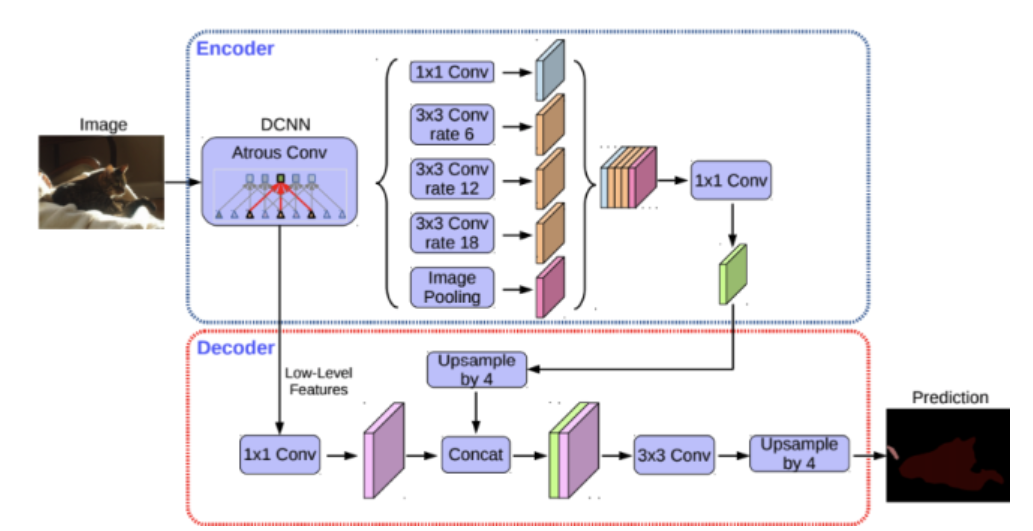

In [12]:
class ModelDeepLabV3Plus(torch.nn.Module):
    def __init__(self, cfg, outputs_desc):
        super().__init__()
        self.outputs_desc = outputs_desc
        ch_out = sum(outputs_desc.values())

        self.encoder = Encoder(
            cfg.model_encoder_name,
            pretrained=cfg.pretrained,
            zero_init_residual=True,
            replace_stride_with_dilation=(False, False, False),
        )
        # ch_out_encoder_bottleneck: number of channels at op from backbone, ch_out_encoder_4x: num channels at 4x resolution as comp to bottleneck op (i.e. ch_out_encoder_bottleneck) 
        ch_out_encoder_bottleneck, ch_out_encoder_4x = get_encoder_channel_counts(cfg.model_encoder_name)

        self.aspp = ASPP(ch_out_encoder_bottleneck, 256)

        self.decoder = DecoderDeeplabV3p(256, ch_out_encoder_4x, ch_out)

    def forward(self, x):
        input_resolution = (x.shape[2], x.shape[3])

        features = self.encoder(x)

        # Uncomment to see the scales of feature pyramid with their respective number of channels.
        # print(", ".join([f"{k}:{v.shape[1]}" for k, v in features.items()]))

        lowest_scale = max(features.keys())

        features_lowest = features[lowest_scale]

        features_tasks = self.aspp(features_lowest)

        predictions_4x, _ = self.decoder(features_tasks, features[4])

        predictions_1x = F.interpolate(predictions_4x, size=input_resolution, mode='bilinear', align_corners=False)

        out = {}
        offset = 0

        for task, num_ch in self.outputs_desc.items():
            current_prediction = predictions_1x[:, offset:offset+num_ch, :, :]
            # be sure that invdepth is > 0, you can use other operators than exp, check later ?? Sachin
            out[task] = current_prediction.exp().clamp(1/300.0, 1/4) if task == "invdepth" else current_prediction
            offset += num_ch

        return out
        

In [13]:
class ModelAdaptiveDepth(nn.Module):
    pass

In [14]:
class ModelDeepLabV3PlusMultiTask(nn.Module):
    pass

In [15]:
def resolve_model_class(name):
    return {
        'deeplabv3p': ModelDeepLabV3Plus,
        'adaptive_depth': ModelAdaptiveDepth,
        'deeplabv3p_multitask': ModelDeepLabV3PlusMultiTask,
    }[name]

def resolve_optimizer(cfg, params):
    if cfg.optimizer == 'sgd':
        return SGD(
            params,
            lr=cfg.optimizer_lr,
            momentum=cfg.optimizer_momentum,
            weight_decay=cfg.optimizer_weight_decay,
        )
    elif cfg.optimizer == 'adam':
        return Adam(
            params,
            lr=cfg.optimizer_lr,
            weight_decay=cfg.optimizer_weight_decay,
        )
    else:
        raise NotImplementedError

def resolve_lr_scheduler(cfg, optimizer):
    if cfg.lr_scheduler == 'poly':
        return LambdaLR(
            optimizer,
            lambda ep: max(1e-5, (1 - ep / cfg.num_epochs) ** cfg.lr_scheduler_power)
        )
    else:
        raise NotImplementedError

In [16]:
class ExperimentDepthSemseg(pl.LightningModule):
    def __init__(self, cfg, train_ds, val_ds, test_ds):
        super(ExperimentDepthSemseg, self).__init__()
        self.cfg = cfg
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.test_ds = test_ds
        # save the config using pl save_hyperparameters() method, pl will save it along with model
        self.save_hyperparameters(cfg.__dict__)

        #{{ get some stats of the dataset
        self.rgb_mean = self.train_ds.rgb_mean
        self.rgb_stddev = self.train_ds.rgb_stddev
        
        self.depth_meters_mean = self.train_ds.depth_meters_mean
        self.depth_meters_stddev = self.train_ds.depth_meters_stddev
        self.depth_meters_min = self.train_ds.depth_meters_min
        self.depth_meters_max = self.train_ds.depth_meters_max

        self.semseg_num_classes = self.train_ds.semseg_num_classes
        self.semseg_ignore_label = self.train_ds.semseg_ignore_label
        self.semseg_class_names = self.train_ds.semseg_class_names
        self.semseg_class_colors = self.train_ds.semseg_class_colors
        #}}

        #{{ get the transforms and set in the corresponding dataset object
        # transforms for train ds
        self.train_ds.set_transforms(get_transforms(
            semseg_ignore_label=self.semseg_ignore_label,
            geom_scale_min=cfg.aug_geom_scale_min,
            geom_scale_max=cfg.aug_geom_scale_max,
            geom_tilt_max_deg=cfg.aug_geom_tilt_max_deg,
            geom_wiggle_max_ratio=cfg.aug_geom_wiggle_max_ratio,
            geom_reflect=cfg.aug_geom_reflect,
            crop_random=cfg.aug_input_crop_size,
            rgb_mean=self.rgb_mean,
            rgb_stddev=self.rgb_stddev,
            depth_meters_mean=self.depth_meters_mean,
            depth_meters_stddev=self.depth_meters_stddev,
        ))
        # transforms for val ds
        self.val_tfs = get_transforms(
            semseg_ignore_label=self.semseg_ignore_label,
            crop_for_passable=32,
            rgb_mean=self.rgb_mean,
            rgb_stddev=self.rgb_stddev,
            depth_meters_mean=self.depth_meters_mean,
            depth_meters_stddev=self.depth_meters_stddev,
        )
        self.val_ds.set_transforms(self.val_tfs)
        # transforms for test ds
        self.test_ds.set_transforms(self.val_tfs)
        #}}

        #{{ set the loss function
        self.loss_semseg = CrossEntropyLoss(ignore_index=self.semseg_ignore_label)
        self.loss_depth = SILogLoss(gamma=0.15)
        #}}

        #{{ set the metrics
        self.metrics_semseg = MetricsSemseg(self.semseg_num_classes, self.semseg_ignore_label, self.semseg_class_names)
        self.metrics_depth = MetricsInvDepth()
        #}}

        #{{ instantiate/build the model
        self.instantiate_model(cfg)
        #}}

        # ?? what about optimizers

    def instantiate_mode(self, cfg):
        self.outputs_descriptor = {
            MOD_SEMSEG: self.semseg_num_classes,
            MOD_DEPTH: 1,
        }
        # get the class name corresponding to model_name to be instantiated
        #pdb.set_trace()
        model_class = resolve_model_class(cfg.model_name)
        # create model from the class
        self.net = model_class(cfg, self.outputs_descriptor)
        print(self.net)

    def configure_optimizers(self):
        optimizer = resolve_optimizer(self.cfg, self.parameters())
        #lr_scheduler = resolve_lr_scheduler(self.cfg, optimizer)
        lr_scheduler = LambdaLR( optimizer,
            lambda ep: max(1e-6, (1 - ep / cfg.num_epochs) ** cfg.lr_scheduler_power)
        )
        #return [optimizer], [lr_scheduler]
        return {'optimizer': optimizer, 
                'lr_scheduler': {"scheduler": lr_scheduler, "interval": "epoch"}
               }

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            self.cfg.batch_size,
            shuffle=True,
            num_workers=self.cfg.workers,
            pin_memory=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            self.cfg.batch_size_validation,
            shuffle=False,
            num_workers=self.cfg.workers_validation,
            pin_memory=True,
            drop_last=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            self.cfg.batch_size_validation,
            shuffle=False,
            num_workers=self.cfg.workers_validation,
            pin_memory=True,
            drop_last=False,
        )

        

### Semantic Segmentation class

In [17]:
class ExperimentSemseg(ExperimentDepthSemseg):
    def __init__(self, cfg, train_ds, val_ds, test_ds):
        super(ExperimentSemseg, self).__init__(cfg=cfg, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds)
        #pdb.set_trace()

    def instantiate_model(self, cfg):
        self.outputs_descriptor = {
            MOD_SEMSEG: self.semseg_num_classes,
        }
        #pdb.set_trace()
        model_class = resolve_model_class(cfg.model_name)
        self.net = model_class(cfg, self.outputs_descriptor)
        print(self.net)

    def training_step(self, batch, batch_nb):
        #pdb.set_trace()
        # get the data and label
        rgb = batch[MOD_RGB]
        y_semseg_lbl = batch[MOD_SEMSEG].squeeze(1) #?? why

        # move data, label to device
        if torch.cuda.is_available():
            rgb = rgb.cuda()
            y_semseg_lbl = y_semseg_lbl.cuda()

        # get predictions
        y_hat = self.net(rgb)
        y_hat_semseg = y_hat[MOD_SEMSEG]

        # get the loss using loss function, our case will go to else
        if isinstance(y_hat_semseg, list):
            # deep supervision scenario: penalize all predicitons in the list and average losses
            loss_semseg = sum([self.loss_semseg(y_hat_semseg_i, y_semseg_lbl) for y_hat_semseg_i in y_hat_semseg])
            loss_semseg = loss_semseg / len(y_hat_semseg)
            y_hat_semseg = y_hat_semseg[-1]
        else:
            loss_semseg = self.loss_semseg(y_hat_semseg, y_semseg_lbl)

        # weighting only for joint training of seg and depth
        loss_total = self.cfg.loss_weight_semseg * loss_semseg
        
        # log the loss
        if 1:
            self.log_dict({
                    'loss_train/semseg': loss_semseg,
                    'loss_train/total': loss_total,
                }, on_step=True, on_epoch=False, prog_bar=True
            )
        
        if self.can_visualize():
            self.visualize(batch, y_hat_semseg, batch[MOD_ID], 'imgs_train/batch_crops')

        return {
            'loss': loss_total,
        }


    def inference_step(self, batch):
        rgb = batch[MOD_RGB]

        if torch.cuda.is_available():
            rgb = rgb.cuda()

        y_hat = self.net(rgb)
        y_hat_semseg = y_hat[MOD_SEMSEG]

        if isinstance(y_hat_semseg, list):
            y_hat_semseg = y_hat_semseg[-1]

        y_hat_semseg_lbl = y_hat_semseg.argmax(dim=1)

        return y_hat_semseg, y_hat_semseg_lbl

    
    def validation_step(self, batch, batch_nb):
        y_hat_semseg, y_hat_semseg_lbl = self.inference_step(batch)

        y_semseg_lbl = batch[MOD_SEMSEG].squeeze(1)

        if torch.cuda.is_available():
            y_semseg_lbl = y_semseg_lbl.cuda()

        loss_val_semseg = self.loss_semseg(y_hat_semseg, y_semseg_lbl)

        self.metrics_semseg.update_batch(y_hat_semseg_lbl, y_semseg_lbl)

        self.log_dict({
                'loss_val/semseg': loss_val_semseg,
                'loss_val/total': loss_val_semseg,
            }, on_step=False, on_epoch=True
        )

    def test_step(self, batch, batch_nb):
        # get the predicted label
        _, y_hat_semseg_lbl = self.inference_step(batch)
                
        # create DIR to store the predicted segmentation image
        path_pred = os.path.join(self.cfg.log_dir, 'predictions')
        path_pred_semseg = os.path.join(path_pred, MOD_SEMSEG)
        if batch_nb == 0:
            os.makedirs(path_pred_semseg)
            
        for i in range(y_hat_semseg_lbl.shape[0]): # for every image in the batch
            sample_name = self.test_ds.name_from_index(batch[MOD_ID][i])
            path_file_semseg = os.path.join(path_pred_semseg, f'{sample_name}.png')
            pred_semseg = y_hat_semseg_lbl[i]
            self.test_ds.save_semseg(
                path_file_semseg, pred_semseg, self.semseg_class_colors, self.semseg_ignore_label
            )

    def validation_epoch_end(self, outputs):
        self.observer_step()

        metrics_semseg = self.metrics_semseg.get_metrics_summary()
        self.metrics_semseg.reset()

        #metric_semseg = (metrics_semseg['mean_iou'] - 50).clamp(min=0)
        metric_semseg = (metrics_semseg['mean_iou']).clamp(min=0)

        scalar_logs = {
            'metrics_summary/semseg': metric_semseg,
            'metrics_summary/total': metric_semseg,
            'trainer/LR': torch.tensor(self.trainer.lr_schedulers[0]["scheduler"].get_last_lr()[0]),
        }
        scalar_logs.update({f'metrics_task_semseg/{k.replace(" ", "_")}': v for k, v in metrics_semseg.items()})

        self.log_dict(scalar_logs, on_step=False, on_epoch=True)

    def visualize(self, batch, y_hat_semseg, rgb_tags, tag):
        """
        batch : input dictionary, {'rgb': data, 'semseg': data, 'depth': data, 'id': id}
        y_hat_semseg : predictions for semantic segmentation from network (logits)
        rgb_tags : batch['id'] (just file id)
        tag : ??
        """
        batch = {k: v.cpu().detach() for k, v in batch.items() if torch.is_tensor(v)}
        y_hat_semseg_lbl = y_hat_semseg.cpu().detach().argmax(dim=1) # dim=1 since <B,C,H,W>
        visualization_plan = [
            (MOD_RGB, batch[MOD_RGB], rgb_tags),
            (MOD_SEMSEG, batch[MOD_SEMSEG], 'GT SemSeg'),
            (MOD_SEMSEG, y_hat_semseg_lbl, 'Prediction SemSeg'),
        ]
        vis = compose(
            visualization_plan,
            self.cfg,
            rgb_mean=self.rgb_mean,
            rgb_stddev=self.rgb_stddev,
            semseg_color_map=self.semseg_class_colors,
            semseg_ignore_label=self.semseg_ignore_label,
        )
        if 1:
            # Use commit=False to not increment the step counter
            self.logger.experiment[0].log({
                tag: [wandb.Image(vis.cpu(), caption=tag)]
            }, commit=False)

    def can_visualize(self):
        return (not torch.cuda.is_available() or torch.cuda.current_device() == 0) and (
                self.global_step - self.cfg.num_steps_visualization_first) % \
                self.cfg.num_steps_visualization_interval == 0

    def observer_step(self):
        if torch.cuda.is_available() and torch.cuda.current_device() != 0:
            return
        vis_transforms = self.val_tfs
        list_samples = []
        for i in self.cfg.observe_train_ids:
            list_samples.append(self.train_ds.get(i, override_transforms=vis_transforms))
        for i in self.cfg.observe_valid_ids:
            list_samples.append(self.val_ds.get(i, override_transforms=vis_transforms))
        list_prefix = ('imgs_train/', ) * len(self.cfg.observe_train_ids) + ('imgs_val/', ) * len(self.cfg.observe_valid_ids)
        batch = default_collate(list_samples)
        rgb = batch[MOD_RGB]
        rgb_tags = [f'{prefix}{id}' for prefix, id in zip(list_prefix, batch[MOD_ID])]
        with torch.no_grad():
            if torch.cuda.is_available():
                rgb = rgb.cuda()
            y_hat = self.net(rgb)
            y_hat_semseg = y_hat[MOD_SEMSEG]
            if isinstance(y_hat_semseg, list):
                y_hat_semseg = y_hat_semseg[-1]
        self.visualize(batch, y_hat_semseg, rgb_tags, 'imgs_val/observed_samples')
        

In [18]:
class Config():
    def __init__(self):
        # set up configs
        self.log_dir = "./LOG_DIR"
        self.dataset_root = "C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/"
        self.name = "Seg-0"
        self.resume = None

        # batches, epochs
        self.batch_size = 16#4 # training
        self.num_epochs = 100
        self.batch_size_validation = 16 #8

        # augmentations
        self.aug_input_crop_size = 256
        self.aug_geom_scale_min = 1
        self.aug_geom_scale_max = 1
        self.aug_geom_tilt_max_deg = 0
        self.aug_geom_wiggle_max_ratio = 0
        self.aug_geom_reflect = False

        # optimizers
        self.optimizer = "adam"
        self.optimizer_lr = 1e-4 #0.01 # at start of training
        self.optimizer_momentum = 0.9
        self.optimizer_weight_decay = 0.01
        self.optimizer_float_16 = False

        # scheduler
        self.lr_scheduler = 'poly' # polynomial scheduler, internally LambdaLR from torch is called which bring down lr at end of every epoch
        self.lr_scheduler_power = 0.9 # polynomial power for learning rate

        #self.dataset = ""  #choices=['miniscapes']
        self.tasks = "semseg"    #choices=['depth', 'semseg']
        
        self.model_name = "deeplabv3p" #choices=['deeplabv3p', 'deeplabv3p_multitask', 'adaptive_depth']
        self.model_encoder_name = 'resnet18' # choices=['resnet18', 'resnet34']
        self.pretrained = True # for self.model_encoder_name
        
        self.loss_weight_semseg = 0.5
        self.loss_weight_depth = 0.5
        
        self.workers = 16 # for train data
        self.workers_validation = 4 # for val data

        self.num_steps_visualization_first = 100 #visualization: first time step
        self.num_steps_visualization_interval = 1000 #Visualization: interval in steps
        self.visualize_num_samples_in_batch = 8 #Visualization: max number of samples in batch
        self.visualize_img_grid_width = 8 #Visualization: number of samples per row
        
        self.observe_train_ids =  [1,100] #'Visualization: train IDs' '[0,100]' ??
        self.observe_valid_ids = [1,100] # 'Visualization: valid IDs' '[0,100]' ??     

        
        self.prepare_submission = False

cfg = Config()


In [19]:
#visualizations related
@torch.no_grad()
def make_grid(
    tensor: Union[torch.Tensor, List[torch.Tensor]],
    nrow: int = 8,
    padding: int = 2,
    normalize: bool = False,
    value_range: Optional[Tuple[int, int]] = None,
    scale_each: bool = False,
    pad_value: float = 0.0,
) -> torch.Tensor:
    """
    Make a grid of images.

    Args:
        tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
            or a list of images all of the same size.
        nrow (int, optional): Number of images displayed in each row of the grid.
            The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
        padding (int, optional): amount of padding. Default: ``2``.
        normalize (bool, optional): If True, shift the image to the range (0, 1),
            by the min and max values specified by ``value_range``. Default: ``False``.
        value_range (tuple, optional): tuple (min, max) where min and max are numbers,
            then these numbers are used to normalize the image. By default, min and max
            are computed from the tensor.
        scale_each (bool, optional): If ``True``, scale each image in the batch of
            images separately rather than the (min, max) over all images. Default: ``False``.
        pad_value (float, optional): Value for the padded pixels. Default: ``0``.

    Returns:
        grid (Tensor): the tensor containing grid of images.
    """
    if not torch.jit.is_scripting() and not torch.jit.is_tracing():
        _log_api_usage_once(make_grid)
    if not torch.is_tensor(tensor):
        if isinstance(tensor, list):
            for t in tensor:
                if not torch.is_tensor(t):
                    raise TypeError(f"tensor or list of tensors expected, got a list containing {type(t)}")
        else:
            raise TypeError(f"tensor or list of tensors expected, got {type(tensor)}")

    # if list of tensors, convert to a 4D mini-batch Tensor
    if isinstance(tensor, list):
        tensor = torch.stack(tensor, dim=0)

    if tensor.dim() == 2:  # single image H x W
        tensor = tensor.unsqueeze(0)
    if tensor.dim() == 3:  # single image
        if tensor.size(0) == 1:  # if single-channel, convert to 3-channel
            tensor = torch.cat((tensor, tensor, tensor), 0)
        tensor = tensor.unsqueeze(0)

    if tensor.dim() == 4 and tensor.size(1) == 1:  # single-channel images
        tensor = torch.cat((tensor, tensor, tensor), 1)

    if normalize is True:
        tensor = tensor.clone()  # avoid modifying tensor in-place
        if value_range is not None and not isinstance(value_range, tuple):
            raise TypeError("value_range has to be a tuple (min, max) if specified. min and max are numbers")

        def norm_ip(img, low, high):
            img.clamp_(min=low, max=high)
            img.sub_(low).div_(max(high - low, 1e-5))

        def norm_range(t, value_range):
            if value_range is not None:
                norm_ip(t, value_range[0], value_range[1])
            else:
                norm_ip(t, float(t.min()), float(t.max()))

        if scale_each is True:
            for t in tensor:  # loop over mini-batch dimension
                norm_range(t, value_range)
        else:
            norm_range(tensor, value_range)

    if not isinstance(tensor, torch.Tensor):
        raise TypeError("tensor should be of type torch.Tensor")
    if tensor.size(0) == 1:
        return tensor.squeeze(0)

    # make the mini-batch of images into a grid
    nmaps = tensor.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.size(2) + padding), int(tensor.size(3) + padding)
    num_channels = tensor.size(1)
    grid = tensor.new_full((num_channels, height * ymaps + padding, width * xmaps + padding), pad_value)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            # Tensor.copy_() is a valid method but seems to be missing from the stubs
            # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.copy_
            grid.narrow(1, y * height + padding, height - padding).narrow(  # type: ignore[attr-defined]
                2, x * width + padding, width - padding
            ).copy_(tensor[k])
            k = k + 1
    return grid



class ImageTextRenderer:
    def __init__(self, size=60):
        font_path = findfont(FontProperties(family='monospace'))
        self.font = ImageFont.truetype(font_path, size=size, index=0)
        self.size = size

    def print_gray(self, img_np_f, text, offs_xy, white=1.0):
        assert len(img_np_f.shape) == 2, "Image must be single channel"
        img_pil = Image.fromarray(img_np_f, mode='F')
        ctx = ImageDraw.Draw(img_pil)
        step = self.size // 15
        for dx, dy in ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)):
            ctx.text((offs_xy[0] + step * dx, offs_xy[1] + step * dy), text, font=self.font, fill=0.0)
        ctx.text(offs_xy, text, font=self.font, fill=white)
        return np.array(img_pil)

    def print(self, img_np_f, text, offs_xy, **kwargs):
        if len(img_np_f.shape) == 3:
            for ch in range(3):
                img_np_f[ch] = self.print_gray(img_np_f[ch], text, offs_xy, **kwargs)
        else:
            img_np_f = self.print_gray(img_np_f, text, offs_xy, **kwargs)
        return img_np_f


_text_renderers = dict()


def get_text_renderer(size):
    if size not in _text_renderers:
        _text_renderers[size] = ImageTextRenderer(size)
    return _text_renderers[size]


def img_print(*args, **kwargs):
    size = kwargs['size']
    del kwargs['size']
    renderer = get_text_renderer(size)
    return renderer.print(*args, **kwargs)


def tensor_print(img, caption, **kwargs):
    if isinstance(caption, str) and len(caption.strip()) == 0:
        return img
    assert img.dim() == 4 and img.shape[1] in (1, 3), 'Expecting 4D tensor with RGB or grayscale'
    offset = min(img.shape[2], img.shape[3]) // 100
    img = img.cpu()
    offset = (offset, offset)
    size = min(img.shape[2], img.shape[3]) // 15
    for i in range(img.shape[0]):
        tag = (caption if isinstance(caption, str) else caption[i]).strip()
        if len(tag) == 0:
            continue
        img_np = img_print(img[i].numpy(), tag, offset, size=size, **kwargs)
        img[i] = torch.from_numpy(img_np)
    return img


def prepare_rgb(img, rgb_mean, rgb_stddev):
    assert img.dim() == 4 and img.shape[1] == 3, 'Expecting 4D tensor with RGB'
    img = img.float().cpu()
    img_mean, img_stddev = torch.tensor(rgb_mean).float().view(3, 1, 1), torch.tensor(rgb_stddev).float().view(3, 1, 1)
    return torch.clamp((img * img_stddev + img_mean) / 255, 0, 1)


def superimpose_rgb(img, rgb, opacity=0.5):
    gray = rgb2gray(rgb)
    img = (1 - opacity) * gray + opacity * img
    return img


def rgb2gray(rgb):
    return rgb[:, 1, :, :].unsqueeze(1).repeat(1, 3, 1, 1)  # RGB -> GGG


def create_checkerboard(N, C, H, W):
    cell_sz = max(min(H, W) // 32, 1)
    mH = (H + cell_sz - 1) // cell_sz
    mW = (W + cell_sz - 1) // cell_sz
    checkerboard = torch.full((mH, mW), 0.25, dtype=torch.float32)
    checkerboard[0::2, 0::2] = 0.75
    checkerboard[1::2, 1::2] = 0.75
    checkerboard = checkerboard.float().view(1, 1, mH, mW)
    checkerboard = F.interpolate(checkerboard, scale_factor=cell_sz, mode='nearest')
    checkerboard = checkerboard[:, :, :H, :W].repeat(N, C, 1, 1)
    return checkerboard


def prepare_semseg(img, semseg_color_map, semseg_ignore_label):
    assert (img.dim() == 3 or img.dim() == 4 and img.shape[1] == 1) and img.dtype in (torch.int, torch.long), \
        f'Expecting 4D tensor with semseg classes, got {img.shape}'
    if img.dim() == 4:
        img = img.squeeze(1)
    colors = torch.tensor(semseg_color_map, dtype=torch.float32)
    assert colors.dim() == 2 and colors.shape[1] == 3
    if torch.max(colors) > 128:
        colors /= 255
    img = img.cpu().clone()  # N x H x W
    N, H, W = img.shape
    img_color_ids = torch.unique(img)
    assert all(c_id == semseg_ignore_label or 0 <= c_id < len(semseg_color_map) for c_id in img_color_ids)
    checkerboard, mask_ignore = None, None
    if semseg_ignore_label in img_color_ids:
        checkerboard = create_checkerboard(N, 3, H, W)
        mask_ignore = img == semseg_ignore_label
        img[mask_ignore] = 0
    img = colors[img]  # N x H x W x 3
    img = img.permute(0, 3, 1, 2)
    if semseg_ignore_label in img_color_ids:
        mask_ignore = mask_ignore.unsqueeze(1).repeat(1, 3, 1, 1)
        img[mask_ignore] = checkerboard[mask_ignore]
    return img


def prepare_mask(mask):
    assert mask.dim() == 4 and mask.shape[1] == 1
    mask = mask.float().cpu()
    out = torch.cat((mask, mask, mask), dim=1)
    return out


def collect_depth_range(img):
    mask_img_valid = img[img == img]
    if mask_img_valid.numel() == 0:
        return 0, 1
    valid_min = torch.min(mask_img_valid).cpu()
    valid_max = torch.max(mask_img_valid).cpu()
    return valid_min, valid_max


def prepare_depth(img, depth_min, depth_max, cmap=None):
    assert img.dim() == 3 or img.dim() == 4 and img.shape[1] == 1, "Invalid number of channels"
    if img.dim() == 4:
        img = torch.squeeze(img, dim=1)
    img_safe = img.clone()
    mask_img_invalid = img_safe != img_safe
    img_safe[mask_img_invalid] = 0
    cm = matplotlib.cm.get_cmap(cmap if cmap is not None else 'plasma_r')

    # scale depth range to [0,1]
    img_01 = ((img_safe - depth_min) / (depth_max - depth_min)).clamp(0, 1)
    # scale logarithmically to highlight close objects
    img_01 = (1 + img_01 * 1000).log() / np.math.log(1001)

    img_colored_np = cm(img_01.cpu().numpy(), bytes=False)[:,:,:,0:3]
    img_colored_np = np.rollaxis(img_colored_np, 3, 1)
    img_colored = torch.tensor(img_colored_np).float()
    mask_img_invalid = torch.unsqueeze(mask_img_invalid, dim=1)
    mask_img_invalid = torch.cat((mask_img_invalid, mask_img_invalid, mask_img_invalid), dim=1)
    checkerboard = create_checkerboard(*mask_img_invalid.shape)
    img_colored[mask_img_invalid] = checkerboard[mask_img_invalid]
    return img_colored


def compose(
        list_triples, cfg,
        rgb_mean=None, rgb_stddev=None, semseg_color_map=None, semseg_ignore_label=None, depth_range=None
):
    if cfg.visualize_num_samples_in_batch is not None:
        list_triples = [(m, img[:cfg.visualize_num_samples_in_batch], c) for (m, img, c) in list_triples]
    N, H, W, rgb = None, None, None, None
    stats_collected = []
    for i, (modality, img, caption) in enumerate(list_triples):
        if modality == MOD_RGB and MOD_RGB not in stats_collected:
            N, _, H, W = img.shape
            rgb = prepare_rgb(img, rgb_mean, rgb_stddev)
            stats_collected.append(MOD_RGB)
        if modality == MOD_DEPTH and MOD_DEPTH not in stats_collected:
            depth_range = collect_depth_range(img)
            stats_collected.append(MOD_DEPTH)
    vis = []
    for i, (modality, img, caption) in enumerate(list_triples):
        if modality == MOD_RGB:
            vis.append(tensor_print(
                rgb.clone(), caption if type(caption) is list else [str(idx) for idx in caption.tolist()])
            )
        elif modality == MOD_SEMSEG:
            vis.append(tensor_print(prepare_semseg(img, semseg_color_map, semseg_ignore_label), caption))
        elif modality == MOD_DEPTH:
            vis.append(tensor_print(prepare_depth(img, *depth_range), caption))
        else:
            assert False, f'Unknown modality {modality}'
    vis = torch.cat(vis, dim=2)
    # N x 3 x H * N_MODS x W
    vis = make_grid(vis, nrow=min(N, cfg.visualize_img_grid_width))
    return vis

def _log_api_usage_once(obj: Any) -> None:

    """
    Logs API usage(module and name) within an organization.
    In a large ecosystem, it's often useful to track the PyTorch and
    TorchVision APIs usage. This API provides the similar functionality to the
    logging module in the Python stdlib. It can be used for debugging purpose
    to log which methods are used and by default it is inactive, unless the user
    manually subscribes a logger via the `SetAPIUsageLogger method <https://github.com/pytorch/pytorch/blob/eb3b9fe719b21fae13c7a7cf3253f970290a573e/c10/util/Logging.cpp#L114>`_.
    Please note it is triggered only once for the same API call within a process.
    It does not collect any data from open-source users since it is no-op by default.
    For more information, please refer to
    * PyTorch note: https://pytorch.org/docs/stable/notes/large_scale_deployments.html#api-usage-logging;
    * Logging policy: https://github.com/pytorch/vision/issues/5052;

    Args:
        obj (class instance or method): an object to extract info from.
    """
    module = obj.__module__
    if not module.startswith("torchvision"):
        module = f"torchvision.internal.{module}"
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{module}.{name}")

def _make_ntuple(x: Any, n: int) -> Tuple[Any, ...]:
    """
    Make n-tuple from input x. If x is an iterable, then we just convert it to tuple.
    Otherwise, we will make a tuple of length n, all with value of x.
    reference: https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/utils.py#L8

    Args:
        x (Any): input value
        n (int): length of the resulting tuple
    """
    if isinstance(x, collections.abc.Iterable):
        return tuple(x)
    return tuple(repeat(x, n))
    


In [20]:
cfg.__dict__

{'log_dir': './LOG_DIR',
 'dataset_root': 'C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/',
 'name': 'Seg-0',
 'resume': None,
 'batch_size': 16,
 'num_epochs': 100,
 'batch_size_validation': 16,
 'aug_input_crop_size': 256,
 'aug_geom_scale_min': 1,
 'aug_geom_scale_max': 1,
 'aug_geom_tilt_max_deg': 0,
 'aug_geom_wiggle_max_ratio': 0,
 'aug_geom_reflect': False,
 'optimizer': 'adam',
 'optimizer_lr': 0.0001,
 'optimizer_momentum': 0.9,
 'optimizer_weight_decay': 0.01,
 'optimizer_float_16': False,
 'lr_scheduler': 'poly',
 'lr_scheduler_power': 0.9,
 'tasks': 'semseg',
 'model_name': 'deeplabv3p',
 'model_encoder_name': 'resnet18',
 'pretrained': True,
 'loss_weight_semseg': 0.5,
 'loss_weight_depth': 0.5,
 'workers': 16,
 'workers_validation': 4,
 'num_steps_visualization_first': 100,
 'num_steps_visualization_interval': 1000,
 'visualize_num_samples_in_batch': 8,
 'visualize_img_grid_width': 8,
 'observe_train_ids': [1, 100],
 'observe_valid_ids': [1, 100],
 'prepare_submission': Fa

In [21]:
# Resolve name task
experiment_name = "Experiment" + "".join(cfg.tasks[0].upper() + cfg.tasks[1:])
model = eval(experiment_name)(cfg, train_ds, val_ds, test_ds)

timestamp = datetime.now().strftime('%#m/%d/%Y-%H%M')
run_name = f'{timestamp}_{cfg.name}_{str(uuid.uuid4())[:5]}'

tube_logger = TestTubeLogger(
    save_dir=cfg.log_dir,
    name='tube',
    version=0,
)
wandb_logger = WandbLogger(
    name=run_name,
    project='CVAIAC-Ex1',
    )

# callback for saving the model
checkpoint_local_callback = ModelCheckpoint(
    dirpath=os.path.join(cfg.log_dir, 'checkpoints'),
    save_last=False,
    save_top_k=1,
    monitor='metrics_summary/total',
    mode='max',
)

# Log information to wandb
#meta = {
#    "Team_Id": TEAM_ID
#}
#wandb_logger.log_hyperparams(meta)

trainer = Trainer(
    logger=[wandb_logger, tube_logger],
    callbacks=[checkpoint_local_callback],
    gpus='-1' if torch.cuda.is_available() else None,
    resume_from_checkpoint=cfg.resume,
    max_epochs=cfg.num_epochs,
    distributed_backend=None,
    weights_summary=None,
    weights_save_path=None,
    num_sanity_val_steps=0,
    precision=16 if cfg.optimizer_float_16 else 32,
    progress_bar_refresh_rate=100,
    log_every_n_steps=50,
    # Uncomment the following options if you want to try out framework changes without training too long
    # limit_train_batches=200,
    # limit_val_batches=10,
    # limit_test_batches=10,
    # log_every_n_steps=10,
)




ModelDeepLabV3Plus(
  (encoder): Encoder(
    (encoder): ResNetBackbone(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
trainer = Trainer(auto_lr_find="optimizer_lr", gpus='-1' if torch.cuda.is_available() else None)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.net.to(device)
lr_finder = trainer.tune(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | loss_semseg | CrossEntropyLoss   | 0     
1 | loss_depth  | SILogLoss          | 0     
2 | net         | ModelDeepLabV3Plus | 16.6 M
---------------------------------------------------
16.6 M    Trainable params
0         Non-trainable params
16.6 M    Total params
66.431    Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at C:\Sachin\CVAIAC2023\cvaiac2023-project-1-main\Sachin\source\lr_find_temp_model.ckpt
Restored all states from the checkpoint file at C:\Sachin\CVAIAC2023\cvaiac2023-project-1-main\Sachin\source\lr_find_temp_model.ckpt
Learning rate set to 0.0009120108393559097


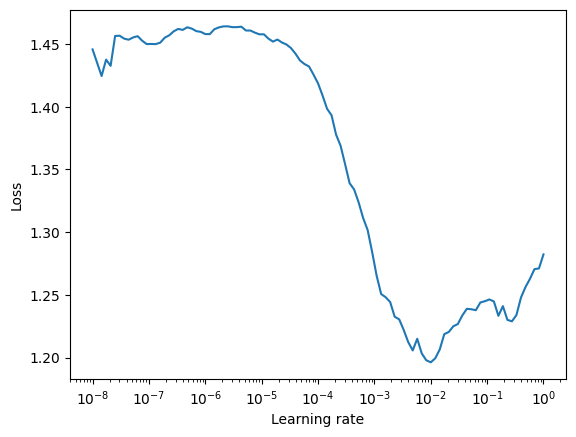

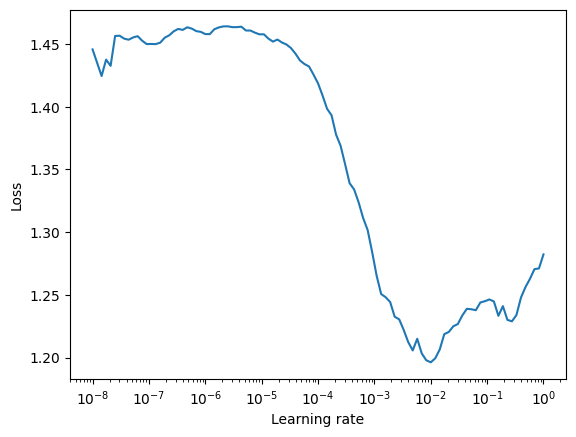

In [28]:
lr_finder['lr_find'].plot()

- Based on above lets start from lr = 1e-3 and clip below by 1e-5 over the number of epochs we want to train using LambdaLR scheduler

In [22]:
model.hparams

"aug_geom_reflect":                 False
"aug_geom_scale_max":               1
"aug_geom_scale_min":               1
"aug_geom_tilt_max_deg":            0
"aug_geom_wiggle_max_ratio":        0
"aug_input_crop_size":              256
"batch_size":                       16
"batch_size_validation":            16
"dataset_root":                     C:/Sachin/CVAIAC2023/synscapes/Synscapes/img/
"log_dir":                          ./LOG_DIR
"loss_weight_depth":                0.5
"loss_weight_semseg":               0.5
"lr_scheduler":                     poly
"lr_scheduler_power":               0.9
"model_encoder_name":               resnet18
"model_name":                       deeplabv3p
"name":                             Seg-0
"num_epochs":                       100
"num_steps_visualization_first":    100
"num_steps_visualization_interval": 1000
"observe_train_ids":                [1, 100]
"observe_valid_ids":                [1, 100]
"optimizer":                        adam
"optimizer_fl

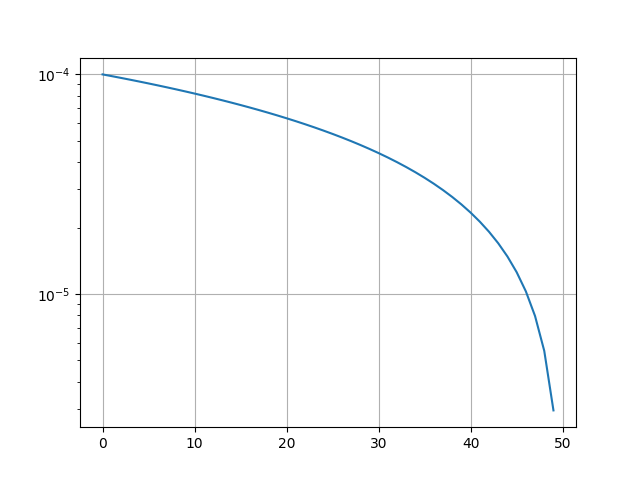

In [35]:
def lr_rate_schedule(cfg):
    lr_rates = []
    for ep in range(cfg.num_epochs):
        lr_rates.append(0.0001 * max(1e-5, (1 - ep / cfg.num_epochs) ** cfg.lr_scheduler_power))
    return np.array(lr_rates)

plt.close('all')
plt.figure()
plt.semilogy(np.arange(cfg.num_epochs), lr_rate_schedule(cfg))
plt.grid(True)

In [23]:
if not cfg.prepare_submission:
    trainer.fit(model)

if 0:
    # prepare submission archive with predictions, source code, training log, and the model
    dir_pred = os.path.join(cfg.log_dir, 'predictions')
    shutil.rmtree(dir_pred, ignore_errors=True)
    trainer.test(model)
    pack_submission(cfg.log_dir, submission_name=f"submission_{run_name}.zip")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: sachin-bharadwaj. Use `wandb login --relogin` to force relogin


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### debug

In [21]:
def create_checkerboard(N, C, H, W):
    cell_sz = max(min(H, W) // 32, 1)
    mH = (H + cell_sz - 1) // cell_sz
    mW = (W + cell_sz - 1) // cell_sz
    checkerboard = torch.full((mH, mW), 0.25, dtype=torch.float32)
    checkerboard[0::2, 0::2] = 0.75
    checkerboard[1::2, 1::2] = 0.75
    checkerboard = checkerboard.float().view(1, 1, mH, mW)
    checkerboard = F.interpolate(checkerboard, scale_factor=cell_sz, mode='nearest')
    checkerboard = checkerboard[:, :, :H, :W].repeat(N, C, 1, 1)
    return checkerboard
    

In [22]:
xx = create_checkerboard(1,8,256,256)

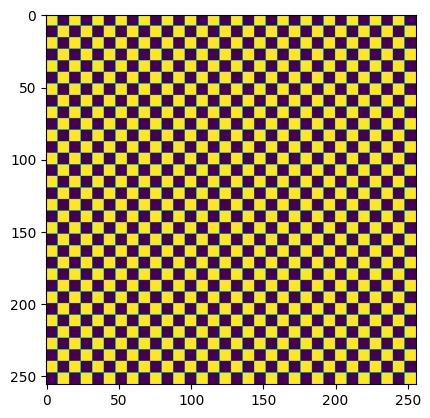

In [24]:
plt.figure()
plt.imshow(xx[0,0])

In [25]:
expsemseg = ExperimentSemseg(cfg, train_ds, val_ds, test_ds)

ModelDeepLabV3Plus(
  (encoder): Encoder(
    (encoder): ResNetBackbone(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [37]:
expsemseg.net.encoder.encoder.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)